In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import torch
from torch import nn, optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

In [2]:
# Load the data from csv file. This is the balanced version of the dataset.
data = pd.read_csv(os.path.join('data', 'train.csv'))

In [3]:
print(data.shape)
l = "toxic"
t = "comment_text"

(159571, 8)


In [4]:
print(data.head())

                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


In [15]:
data.dropna(subset=[t], inplace=True)
data = data[data[t].str.len() > 1]

In [5]:
data["toxic"].value_counts()

toxic
0    144277
1     15294
Name: count, dtype: int64

In [6]:
# Clean data: remove HTML tags and emojis

def clean_text(row):
  text = row[t]
  # remove HTML tags
  text = re.sub(r'<.*?>', '', text)
  # remove emojis
  text = text.encode('ascii', 'ignore').decode('ascii')
  return pd.Series([text, row[l]], index=[t, l])

data = data.apply(clean_text, axis=1)

data.head()

,comment_text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [9]:
# Test function
def clean_text(text):
  # remove HTML tags
  text = re.sub(r'<.*?>', '', text)
  # remove emojis
  text = text.encode('ascii', 'ignore').decode('ascii')
  return text

print(clean_text('<p>hello world </p>'))

hello world 


In [7]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer

/opt/anaconda3/envs/ai_py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
train, validation = train_test_split(data, test_size=0.2, stratify=data[l], random_state=42)

class HateSpeechDataset(Dataset):
    
  def __init__(self, data):
      
    # Initialize BERT tokenizer
    self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')        
    self.data = data
      
      
  def __len__(self):
      return len(self.data)
  
  def __getitem__(self, idx):
    example = self.data.iloc[idx]

    text = example[t]
    label = example[l]

    # Tokenize the text
    encoding = self.tokenizer.encode_plus(text, padding='max_length', truncation=True, max_length=64, return_tensors='pt')
    return {
      "input_ids": encoding["input_ids"].squeeze(0),
      "attention_mask": encoding["attention_mask"], ##.unsqueeze(0).int(),
      "label": label,
    }
  

In [9]:
dataset_train = HateSpeechDataset(train)
dataset_val = HateSpeechDataset(validation)

batch_size = 128
dataloader_train = DataLoader(
  dataset_train,
  batch_size=batch_size,
  shuffle=True,
  num_workers=0,
  collate_fn=lambda x: {
    "input_ids": torch.stack([item["input_ids"] for item in x]),
    "attention_mask": torch.stack([item["attention_mask"] for item in x]),
    "labels": torch.tensor([item["label"] for item in x])
  },
  #collate_fn=data_collator,
  pin_memory=True,
)

dataloader_val = DataLoader(
    dataset_val,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=lambda x: {
        "input_ids": torch.stack([item["input_ids"] for item in x]),
        "attention_mask": torch.stack([item["attention_mask"] for item in x]),
        "labels": torch.tensor([item["label"] for item in x])
    },
    #collate_fn=data_collator,
    pin_memory=True,
)

In [ ]:
class BERTClassifier(nn.Module):
    
  def __init__(self):
      
    # Specify network layers
    super(BERTClassifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-uncased')
    
    self.avg_pool = nn.AdaptiveAvgPool1d(1)
    
    self.linear = nn.Linear(self.bert.config.hidden_size, 1)
    
    # Define dropout
    self.dropout = nn.Dropout(0.1)
    
    # Freeze BERT layers
    for n, p in self.bert.named_parameters():
      p.requires_grad = False
          
  def forward(self, text, masks):
    
    output_bert = self.bert(text, attention_mask=masks).last_hidden_state
    output_bert = self.avg_pool(output_bert.transpose(1, 2)).squeeze(-1)
    
    return self.linear(self.dropout(output_bert))

In [11]:
model = BERTClassifier()
optimizer = optim.Adam(model.parameters(), lr=0.001) #optim.AdamW(model.parameters(), lr=5e-5) #
criterion = nn.BCEWithLogitsLoss()

In [ ]:
# Optional train from previous checkpoint
# model.load_state_dict(torch.load("model/v7/bert_classifier.pth"))

/var/folders/t8/rdxqv77j1bz5zsm7dd6c_szh0000gn/T/ipykernel_73968/123162767.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model/v7/ber

<All keys matched successfully>

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [14]:
epochs = 3

In [15]:
model.to(device)

val_losses = []
train_losses = []

# Train model
for epoch_i in range(0, epochs):
    
  # ========================================
  #               Training
  # ========================================

  model.train()
  print(f"Start training epoch {epoch_i}...")
  total_train_loss = 0
  for i, batch in enumerate(tqdm(dataloader_train)):
  
    optimizer.zero_grad()
    
    input_ids = batch['input_ids'].to(device)
    masks = batch['attention_mask'].to(device)
    label = batch['labels'].to(device) 

    output = model(input_ids, masks)
    loss = criterion(output.squeeze(), label.float())

    loss.backward()
    
    # Clip the norm of the gradients to 1.0 to prevent the "exploding gradients".
    #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    
    total_train_loss += loss.item()
      
  avg_train_loss = total_train_loss / len(dataloader_train)
  train_losses.append(avg_train_loss)
  # ========================================
  #               Validation
  # ========================================
  
  model.eval()
  print("Start validation...")
  y_true_bert = list()
  y_pred_bert = list()
  
  total_eval_loss = 0.0
  with torch.no_grad():
    for batch in dataloader_val:
        input_ids = batch['input_ids'].to(device)
        masks = batch['attention_mask'].to(device)
        label = batch['labels'].to(device)
        
        output = model(input_ids, masks)
        max_output = (torch.sigmoid(output).cpu().numpy().reshape(-1)>= 0.5).astype(int)
        y_true_bert.extend(label.tolist())
        y_pred_bert.extend(max_output.tolist())
        
        loss_v = criterion(output.squeeze(), label.float())
        total_eval_loss += loss.item()
  avg_val_loss = total_eval_loss / len(dataloader_val)
  val_losses.append(avg_val_loss)
  
  print(f"Metrics after Epoch {epoch_i}")     
  print(f"Accuracy : {accuracy_score(y_true_bert, y_pred_bert)}")
  print(f"Presision: {np.round(precision_score(y_true_bert, y_pred_bert),3)}")
  print(f"Recall: {np.round(recall_score(y_true_bert, y_pred_bert),3)}") 
  print(f"F1: {np.round(f1_score(y_true_bert, y_pred_bert),3)}")
  print("   ")  

Start training epoch 0...


100%|██████████| 998/998 [04:47<00:00,  3.47it/s]


Start validation...
Metrics after Epoch 0
Accuracy : 0.9482375058749805
Presision: 0.825
Recall: 0.584
F1: 0.684
   
Start training epoch 1...


100%|██████████| 998/998 [04:52<00:00,  3.41it/s]


Start validation...
Metrics after Epoch 1
Accuracy : 0.950963496788344
Presision: 0.834
Recall: 0.61
F1: 0.705
   
Start training epoch 2...


100%|██████████| 998/998 [04:56<00:00,  3.37it/s]


Start validation...
Metrics after Epoch 2
Accuracy : 0.9520601597994673
Presision: 0.831
Recall: 0.627
F1: 0.715
   


In [16]:
print('Test accuracy: {:.2f}'.format(accuracy_score(y_true_bert, y_pred_bert)))
print('\nClassification report: \n', classification_report(y_true_bert, y_pred_bert))
print('\nConfusion matrix: \n')
display(pd.DataFrame({"Predicted: Unhateful": confusion_matrix(y_true_bert, y_pred_bert)[:, 0], 
              "Predicted: Hateful": confusion_matrix(y_true_bert, y_pred_bert)[:, 1]},
             index=['Actual: Unhateful', 'Actual: Hateful']))

Test accuracy: 0.95

Classification report: 
               precision    recall  f1-score   support

           0       0.96      0.99      0.97     28856
           1       0.83      0.63      0.71      3059

    accuracy                           0.95     31915
   macro avg       0.90      0.81      0.84     31915
weighted avg       0.95      0.95      0.95     31915


Confusion matrix: 



,Predicted: Unhateful,Predicted: Hateful
Actual: Unhateful,28467,389
Actual: Hateful,1141,1918


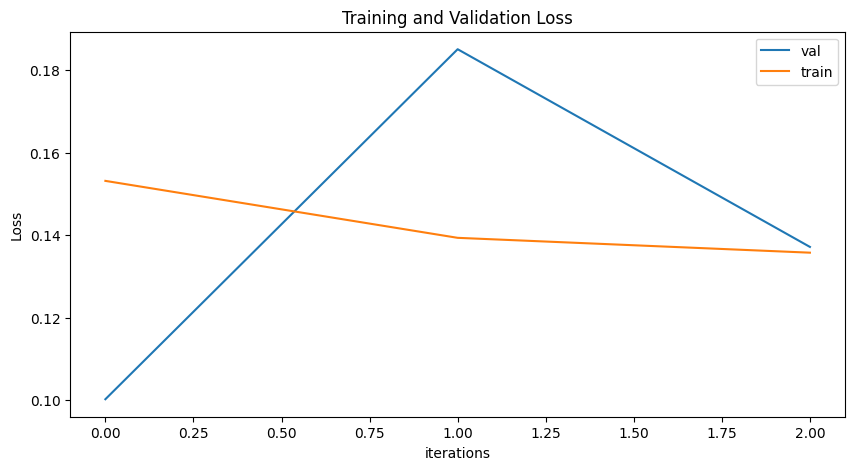

In [17]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [18]:
version = "v8"
save_path = os.path.join('model', version, 'bert_classifier.pth')
# Save the model's state_dict
torch.save(model.state_dict(), save_path)
print("Model state_dict saved to " + str(save_path))


Model state_dict saved to model/v8/bert_classifier.pth
